### 1. Import Libraries/Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Since we will be using XGBoost first, must change object variables to category

In [4]:
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [5]:
for col in train_df.columns:
    print(train_df[col].dtype)

int64
object
object
float64
object
float64
object
object
float64
float64
object
float64


In [6]:
# All columns have the correct data type that I expect them to have.

In [7]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [8]:
for col in train_df.columns:
    print(train_df[col].dtype)

int64
category
category
float64
category
float64
category
category
float64
float64
category
float64


In [9]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

### 2. Set up train and test sets

In [11]:
X = train_df.drop(['id', 'Listening_Time_minutes'], axis=1)
y = train_df['Listening_Time_minutes']
final_train = test_df.drop('id', axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

### 3. Start with base XGBoost model

In [14]:
from xgboost import XGBRegressor
model = XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
predictions = model.predict(X_test)

In [16]:
y_pred = predictions

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_pred, y_test, squared=False)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

In [25]:
print("RMSE: ", rmse, "MAE ", mae, "R2: ", r2)

RMSE:  13.114044802914592 MAE  9.48859713315721 R2:  0.6991389646687252


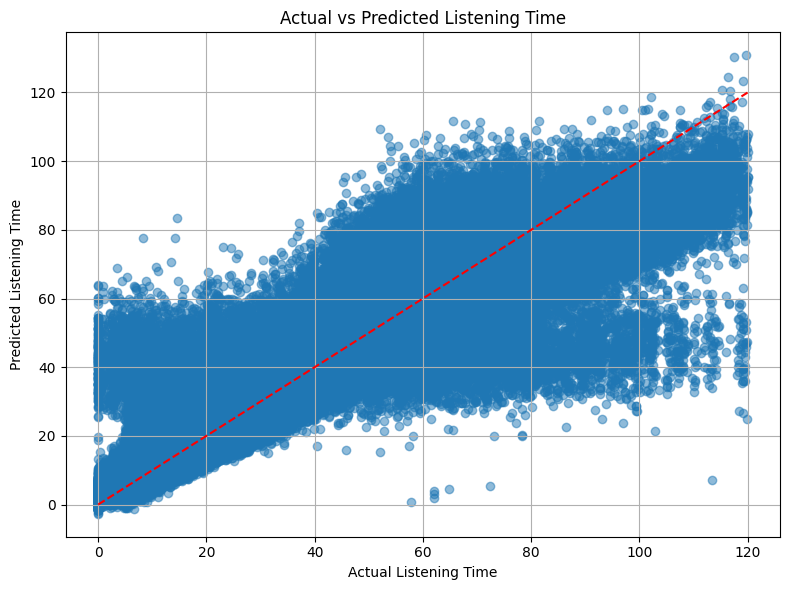

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title("Actual vs Predicted Listening Time")
plt.grid(True)
plt.tight_layout()
plt.show()

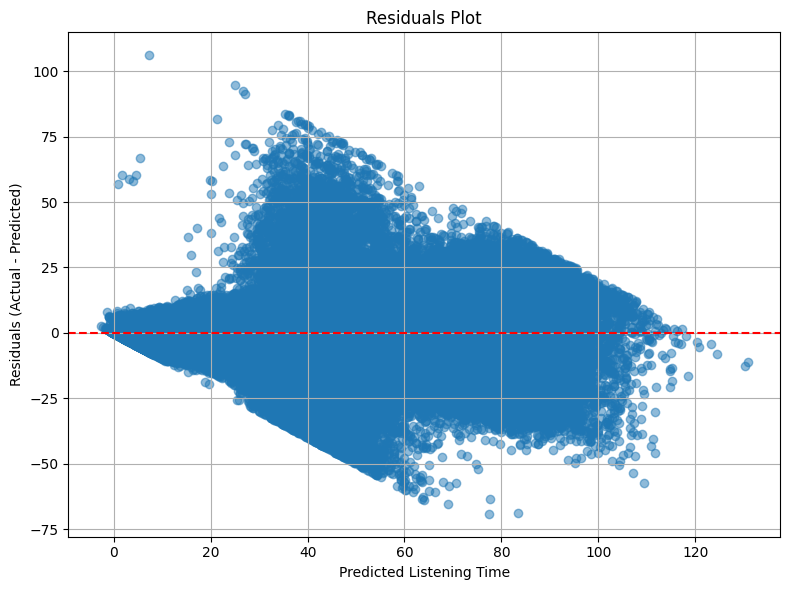

In [35]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# Model tends to heavily underpredict higher listening times. 
# Need to improve model. 

In [38]:
# First, I will apply a log transformation to 
# the y variable, in order to try and minimize the
# scale that higher values impact the RMSE. This
# will ensure the model isn't too conservative with 
# predicting higher values. 

In [40]:
# Will apply np.log1p(x), which is: (log(1+x))

In [41]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [43]:
model = XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    random_state=80
)

model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=80, ...)

In [44]:
predictions = model.predict(X_test)

In [46]:
y_pred = predictions

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_pred, y_test_log, squared=False)
mae = mean_absolute_error(y_pred, y_test_log)
r2 = r2_score(y_pred, y_test_log)

print("RMSE: ", rmse, "MAE ", mae, "R2: ", r2)

RMSE:  0.3971500801944574 MAE  0.26439855522497085 R2:  0.7380409083697931


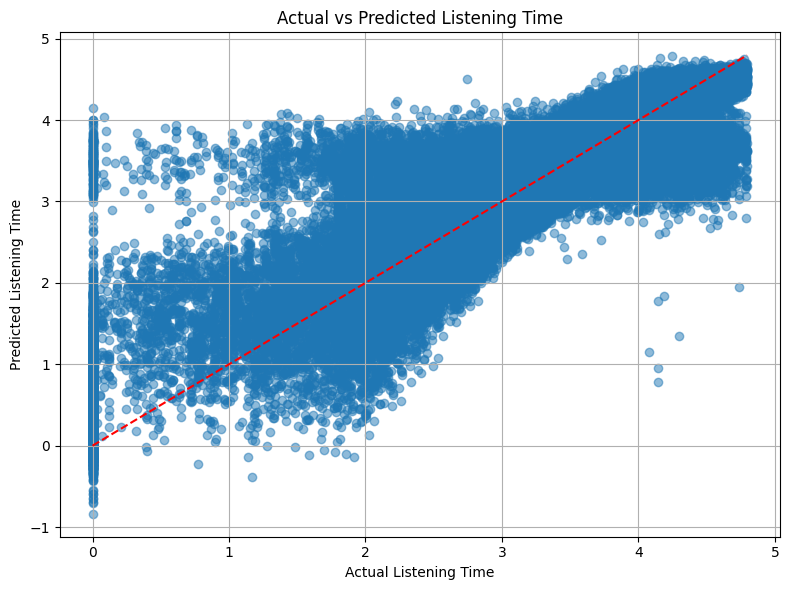

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test_log, y_pred, alpha=0.5)
plt.plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title("Actual vs Predicted Listening Time")
plt.grid(True)
plt.tight_layout()
plt.show()

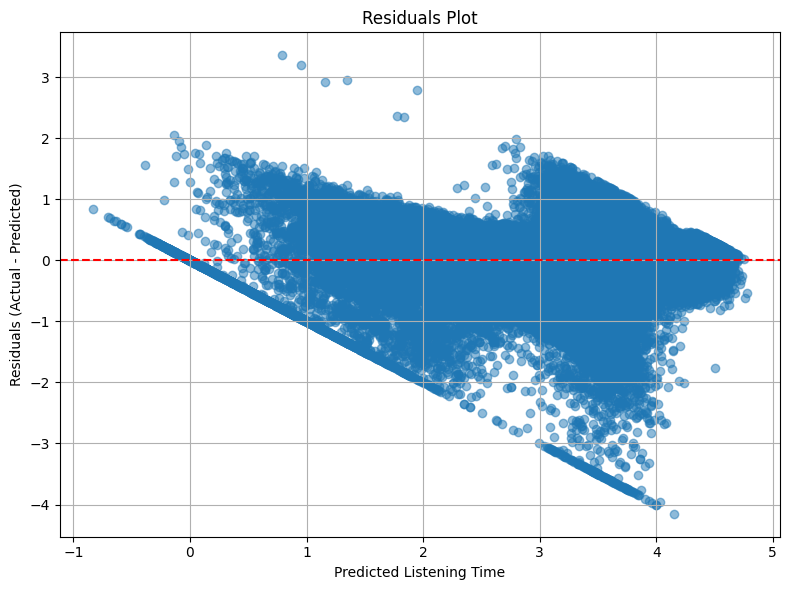

In [49]:
residuals = y_test_log - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

***Not seeing remarkably different results on the graphs, despite better metrics. I am going to look into the features and consider doing some interaction variables, transforming the variables, or perhaps some hyperparameter tuning to see if I can improve the model.***

In [56]:
importances = model.feature_importances_
features = X.columns

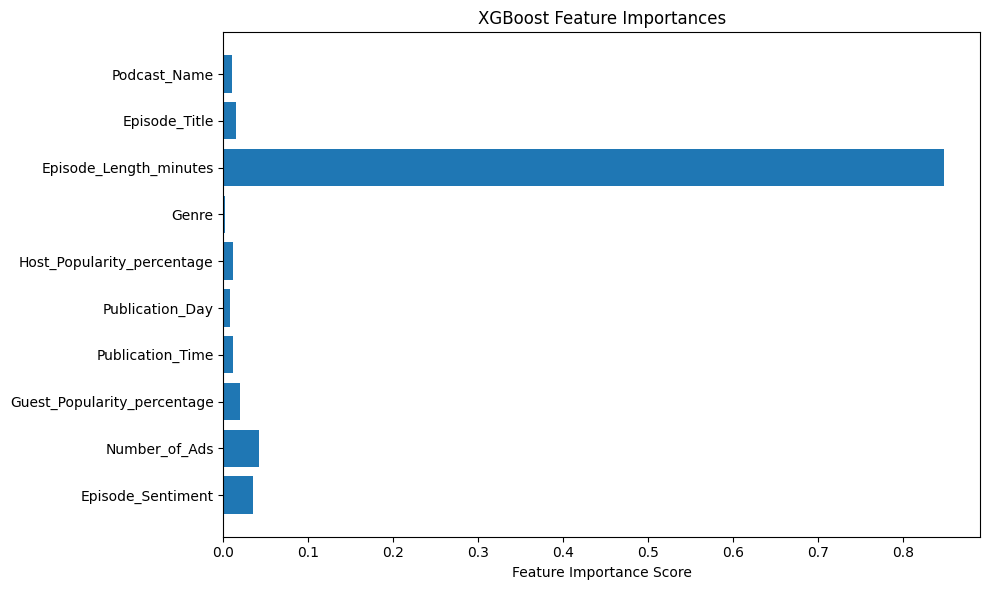

In [57]:
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

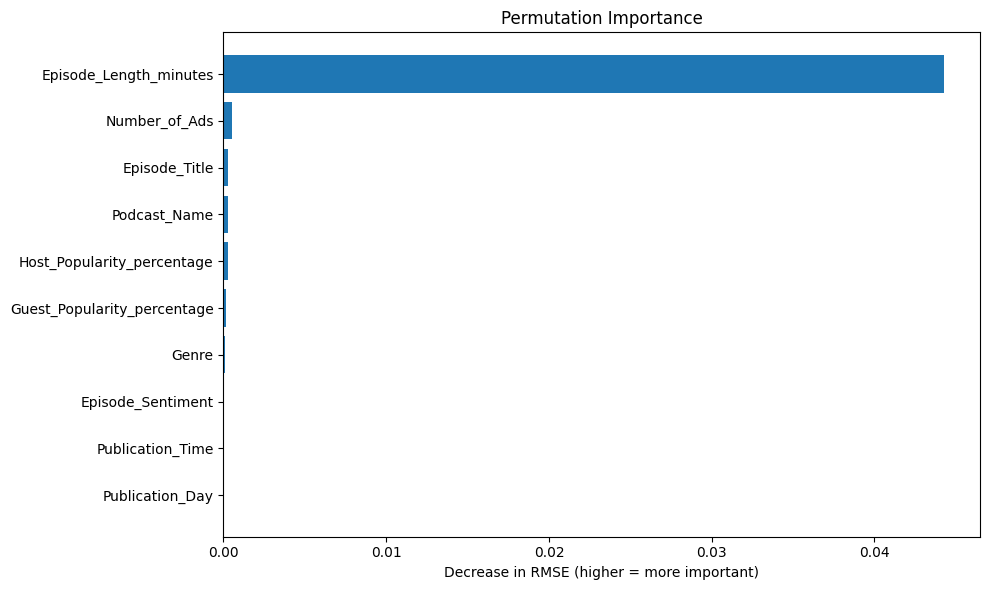

In [59]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=80)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Decrease in RMSE (higher = more important)")
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

***The model is being driven almost entirely by episode length in minutes. I will need to do some feature engineering to get some information from the other variables that the model isn't picking up on.***

In [63]:
# First, I am going to separate the podcasts into "yes" or "no" ads, as a column of 0 and 1. 
# Then, I am creating a column for episode length divided by number of ads, to 
# get the length between ads. 
# This should capture the benefit of having no ads at all, while also capturing the separate
# effect of the amount of ads per minute. 
train_df['binary_ads'] = (train_df['Number_of_Ads'] != 0).astype(int)

In [65]:
train_df['time_between_ads'] = train_df['Episode_Length_minutes'] / (train_df['Number_of_Ads']+1)

In [61]:
# Now, I will fill in missing episode length values with the mean value lengths of that podcast alone.

In [73]:
# The following code gets a list of the mean of each podcast episode's length in minutes,
# in a list of 750,000 in order from the data frame. 
group_means = train_df.groupby('Podcast_Name')['Episode_Length_minutes'].transform('mean')

In [74]:
group_means

0         64.388461
1         61.348252
2         65.980351
3         63.417366
4         66.282002
            ...    
749995    65.276120
749996    66.672731
749997    64.305250
749998    64.390165
749999    60.810536
Name: Episode_Length_minutes, Length: 750000, dtype: float64

In [77]:
train_df['Episode_Length_minutes'] = train_df['Episode_Length_minutes'].fillna(group_means)

In [78]:
train_df

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,binary_ads,time_between_ads
0,0,Mystery Matters,Episode 98,64.388461,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,0,NaN
1,1,Joke Junction,Episode 26,119.800000,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,1,39.933333
2,2,Study Sessions,Episode 16,73.900000,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,0,73.900000
3,3,Digital Digest,Episode 45,67.170000,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,1,22.390000
4,4,Mind & Body,Episode 86,110.510000,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,1,27.627500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.660000,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058,0,75.660000
749996,749996,Business Briefs,Episode 21,75.750000,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242,1,25.250000
749997,749997,Lifestyle Lounge,Episode 51,30.980000,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000,0,30.980000
749998,749998,Style Guide,Episode 47,108.980000,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939,0,108.980000


In [79]:
# Now that all the missing episode lenths are filled in with the means of each episode, we can re-fit the model. 

In [80]:
# Will still apply log transformation to target variable

In [81]:
for col in train_df.columns:
    print(train_df[col].dtype)

int64
category
category
float64
category
float64
category
category
float64
float64
category
float64
int64
float64


In [83]:
X = train_df.drop(['id', 'Listening_Time_minutes'], axis=1)
y = train_df['Listening_Time_minutes']

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=80)

model = XGBRegressor(
    enable_categorical=True,
    tree_method='hist',
    random_state=80
)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

y_pred = predictions

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = mean_squared_error(y_pred, y_test, squared=False)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print("RMSE: ", rmse, "MAE ", mae, "R2: ", r2)

RMSE:  0.39684622170585443 MAE  0.26423713293605433 R2:  0.7385907622297718


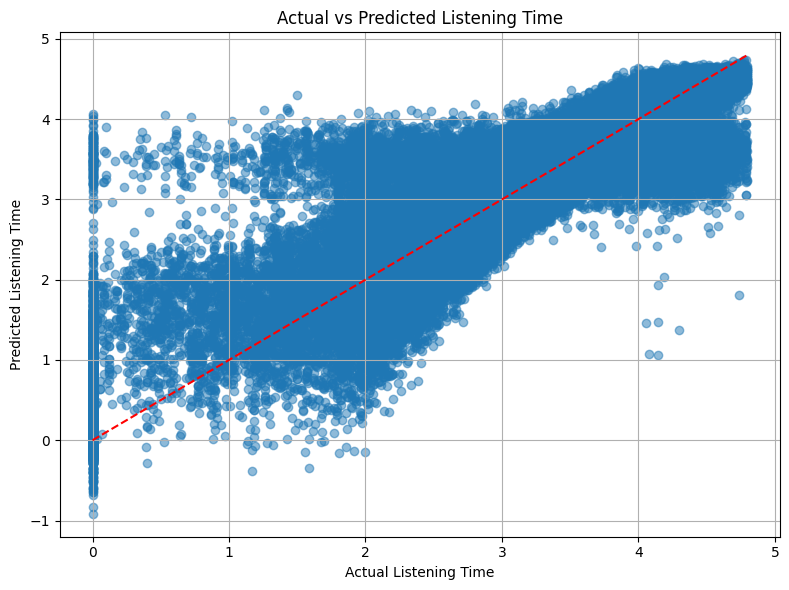

In [84]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Listening Time')
plt.ylabel('Predicted Listening Time')
plt.title("Actual vs Predicted Listening Time")
plt.grid(True)
plt.tight_layout()
plt.show()

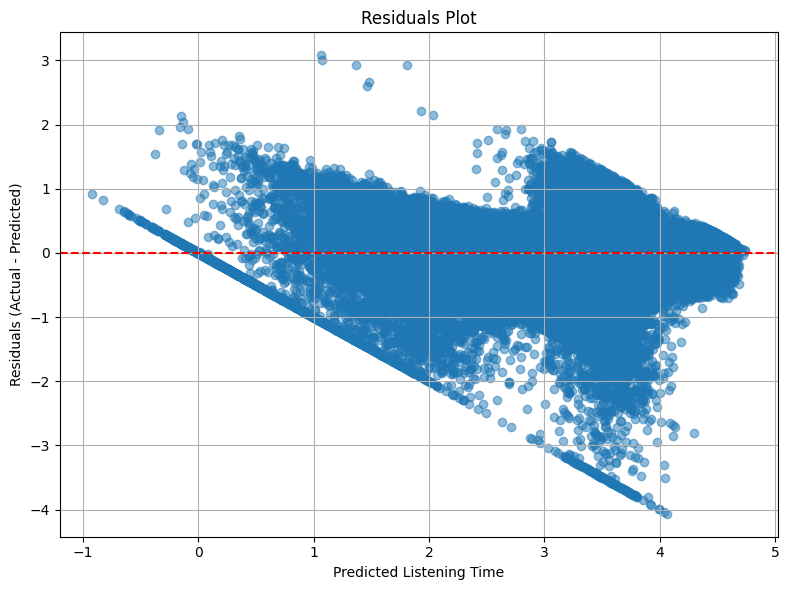

In [85]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Listening Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Plot')
plt.grid(True)
plt.tight_layout()
plt.show()


In [86]:
importances = model.feature_importances_
features = X.columns

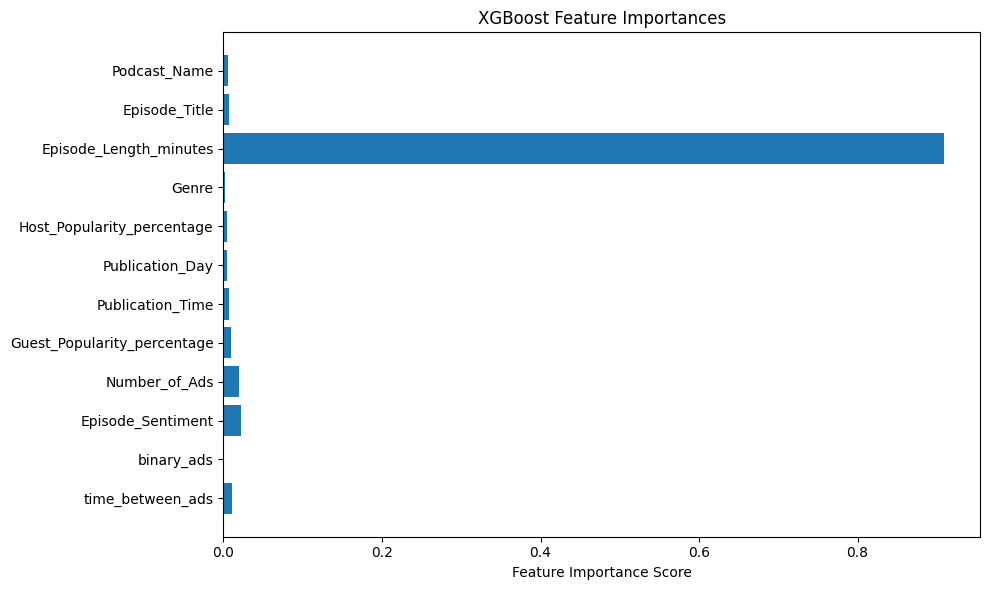

In [87]:
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel("Feature Importance Score")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

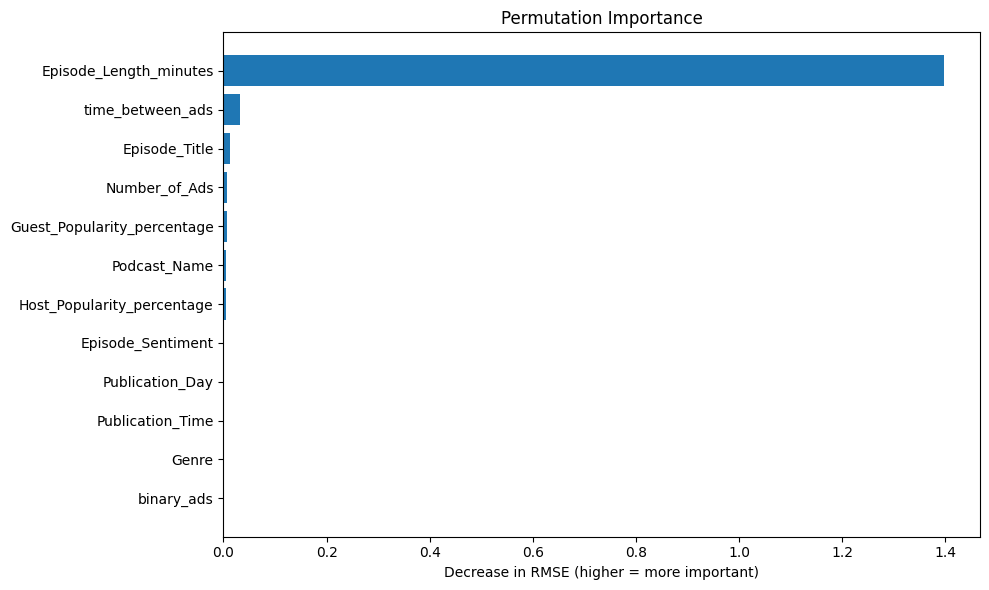

In [88]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=80)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Decrease in RMSE (higher = more important)")
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

***At this point, it is clear that the binary_ads feature is unimportant, but time_between_ads was a valuable feature to add. I will be exploring how to improve this model even further before submitting to Kaggle, and will update as I work on it.***